<a href="https://colab.research.google.com/github/KotiKommineni/GPU_Programming/blob/main/gpu_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! ls


! nvcc --version


!git --version


! git clone https://github.com/andreinechaev/nvcc4jupyter.git

%cd nvcc4jupyter/

%load_ext nvcc_plugin


drive  nvcc4jupyter  sample_data
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
git version 2.25.1
fatal: destination path 'nvcc4jupyter' already exists and is not an empty directory.
/content/nvcc4jupyter
directory /content/nvcc4jupyter/src already exists
Out bin /content/nvcc4jupyter/result.out


In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [3]:
%%cu
#include <iostream>
int main() 
{
    std::cout << "Hello world\n";
    return 0;
}

Hello world



In [4]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "stdio.h"
void addArrays(int*a, int*b, int*c, int count)
{
    for(int i=0; i <count;i++)
    {
         c[i]=a[i]+b[i];
    }
   
}

int main()
{
    const int count = 5;
    int a[] = {1,2,3,4,5};
    int b[] = {10,20,30,40,50};
    int c[count];
    
    addArrays(a,b,c,count);
 
    for(int i=0; i <count;i++)
    {
         printf("%d  ",c[i]);
    }
 return 0;
}

11  22  33  44  55  


In [5]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "stdio.h"

void addArrays(int*a, int*b, int*c, int i)
{
         c[i]=a[i]+b[i];
}

int main()
{
    const int count = 5;
    int a[] = {1,2,3,4,5};
    int b[] = {10,20,30,40,50};
    int c[count];
    
    for(int i=0; i <count;i++)
    {
     addArrays(a,b,c,i);
    }
 
    for(int i=0; i <count;i++)
    {
         printf("%d  ",c[i]);
    }
 return 0;
}

11  22  33  44  55  


In [6]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "stdio.h"

__global__ void addArrays(int*a, int*b, int*c)
{
    int i = threadIdx.x;
         c[i]=a[i]+b[i];
}

int main()
{
    const int count = 5;
    const int size = count*sizeof(int);
    int ha[] = {1,2,3,4,5};
    int hb[] = {10,20,30,40,50};
    int hc[count];
    
    int *da, *db, *dc;
    cudaMalloc(&da, size);
    cudaMalloc(&da, size);
    cudaMalloc(&da, size);
 
    cudaMemcpy(da,ha,size,cudaMemcpyHostToDevice);
    cudaMemcpy(da,ha,size,cudaMemcpyHostToDevice);
 
    addArrays<<<1,count>>>(da,db,dc);
    
    cudaMemcpy(hc,dc,size,cudaMemcpyDeviceToHost);

    for(int i=0; i < count; i++)
    {
         printf("%d  ",hc[i]);
    }
 return 0;
}

0  0  336480912  21912  -1159163824  


**Location Qualifiers**


*   __ __global__ __

         Defines a Kernel.

         Runs on the GPU,  called from the CPU

         Executed with <<dim3>>> arguments

*   __ __device__ __

          Runs on the GPU, called from GPU.
         * Can be used for variables too.

* __ __host__ __

          Runs on the CPU, called from the CPU

* Qualifiers can be mixed
         * E.g __ __host__ __ __ __device__ __ foo()
         * Code compiled for both CPU and GPU
         * Useful for testing








In [7]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
using namespace std;

int main()
{
    int count;
    cudaGetDeviceCount(&count);
    
    cudaDeviceProp prop;
    for(int i = 0; i<count;++i)
    {
        cudaGetDeviceProperties(&prop,i);
     cout << " Device " << i << ": " << prop.name << endl;
     cout << " Compute capability: " << prop.major << "." << prop.minor << endl;
     cout << " Max grid dimensions: (" << 
             prop.maxGridSize[0] << "x " <<
             prop.maxGridSize[1] << "x " <<
             prop.maxGridSize[2] << ")" << endl;

      cout << " Max block dimensions: (" << 
             prop.maxThreadsDim[0] << "x " <<
             prop.maxThreadsDim[1] << "x " <<
             prop.maxThreadsDim[2] << ")" << endl;    

    }
 getchar();
 return 0;
}

 Device 0: Tesla T4
 Compute capability: 7.5
 Max grid dimensions: (2147483647x 65535x 65535)
 Max block dimensions: (1024x 1024x 64)



Parallell Programming Patterns

Rules of the Game

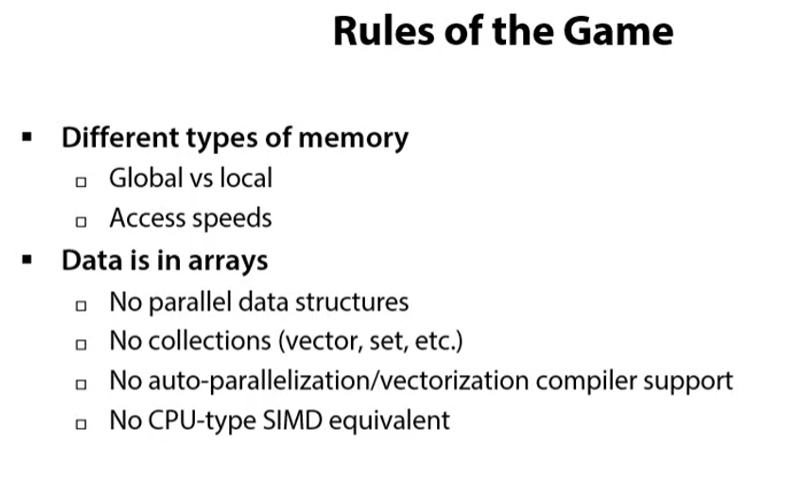

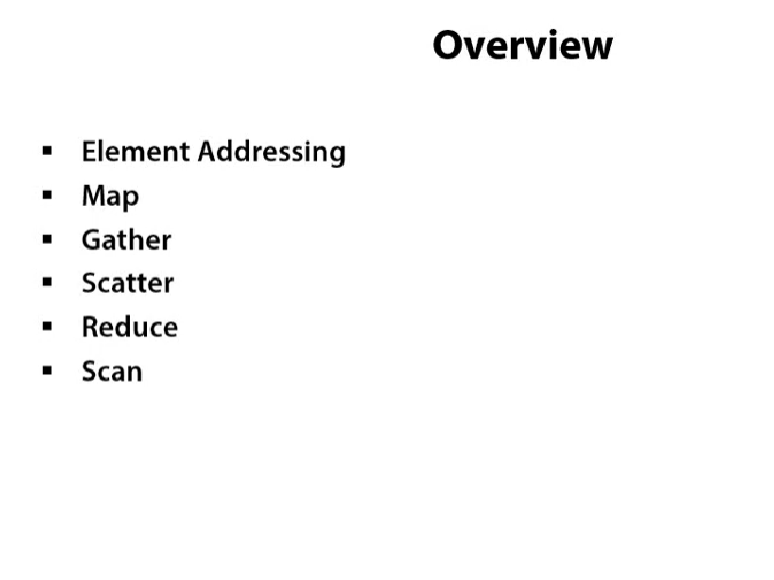

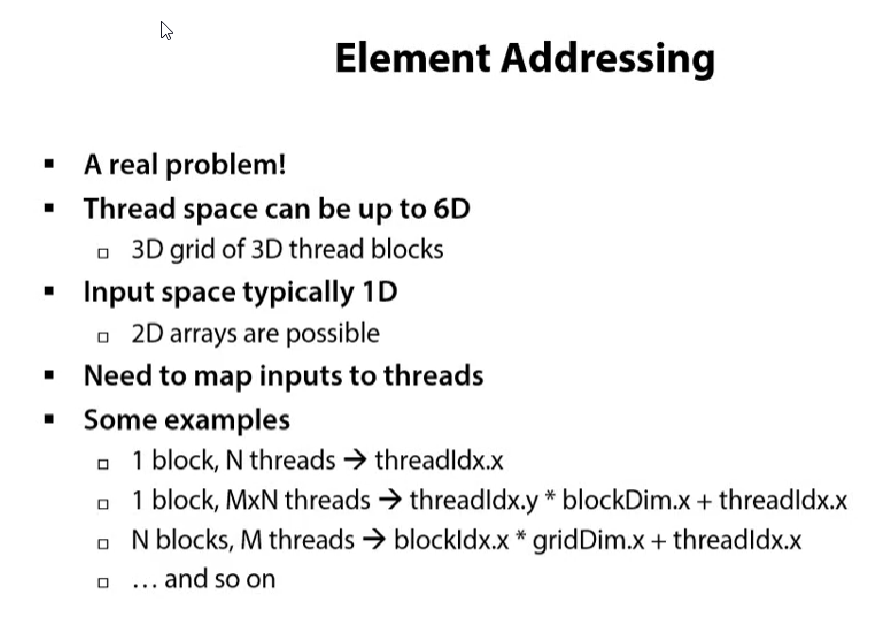

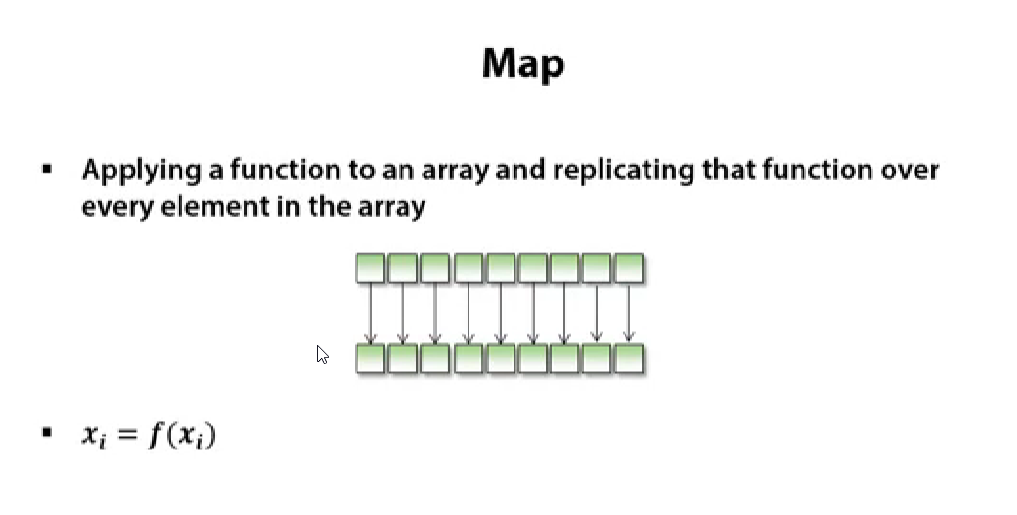

In [9]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "curand.h"

#include <iostream>
#include <ctime>
#include <cstdio>
#include <cuda.h>
#include <curand_kernel.h>
#include <math.h>
using namespace std;

#define CUDA_CALL(x) do { if((x)!=cudaSuccess) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)
#define CURAND_CALL(x) do { if((x)!=CURAND_STATUS_SUCCESS) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)

__global__ void addTen(float* d, int count)
{
    int threadsPerBlock =  blockDim.x * blockDim.y * blockDim.z;
    int threadPosInBlock = threadIdx.x +
                           blockDim.x * threadIdx.y +
                           blockDim.x * blockDim.y * threadIdx.z;
     int blockPosInGrid = blockIdx.x +
                           gridDim.x * blockIdx.y +
                           gridDim.x * gridDim.y * blockIdx.z;
     int tid = blockPosInGrid * threadsPerBlock + threadPosInBlock;
     if(tid < count)
     {
         d[tid] =  d[tid]+10;
     }
}

int main()
{
    
    curandGenerator_t gen;
    curandCreateGenerator(&gen, CURAND_RNG_PSEUDO_MTGP32);
    curandSetPseudoRandomGeneratorSeed(gen, time(0));
 
    const int count = 123456;
    const int size = count* sizeof(float);
    float *d;
    float h[count];
    cudaMalloc(&d, size);
    curandGenerateUniform(gen, d, count);
 
    dim3 block(8,8,8);
    dim3 grid(16,16);
    
    addTen<<<grid,block>>>(d,count);
 
    cudaMemcpy(h,d,size,cudaMemcpyDeviceToHost);
    cudaFree(d);
 
    for (int i = 0; i < 100; i++)
    {
        cout << h[i] << endl;
    }
  
     getchar();
    
    return 0;
}

/usr/bin/ld: /tmp/tmpxft_000067f2_00000000-11_acce49ff-70e1-4c24-93b7-1d51d517d59f.o: in function `main':
tmpxft_000067f2_00000000-6_acce49ff-70e1-4c24-93b7-1d51d517d59f.cudafe1.cpp:(.text+0x61): undefined reference to `curandCreateGenerator'
/usr/bin/ld: tmpxft_000067f2_00000000-6_acce49ff-70e1-4c24-93b7-1d51d517d59f.cudafe1.cpp:(.text+0x80): undefined reference to `curandSetPseudoRandomGeneratorSeed'
/usr/bin/ld: tmpxft_000067f2_00000000-6_acce49ff-70e1-4c24-93b7-1d51d517d59f.cudafe1.cpp:(.text+0xc6): undefined reference to `curandGenerateUniform'
collect2: error: ld returned 1 exit status

